<a href="https://colab.research.google.com/github/Aravindhan0-7/CMCL/blob/main/CMCL_complete_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core Python libraries
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn tqdm

# PyTorch, TorchVision (deep learning framework, GPU support)
!pip install --quiet torch torchvision

# timm: SOTA vision models including ViT (Vision Transformer)
!pip install --quiet timm

# Transformers (Hugging Face) for ViT and TabTransformer models
!pip install --quiet transformers

# MRI image handling (NIfTI format)
!pip install --quiet nibabel pillow

# Microbiome data (.biom files)
!pip install --quiet biom-format

# TabTransformer for tabular data (PyPI version, or use HuggingFace if you prefer)
!pip install --quiet tab-transformer-pytorch

# For visualization and notebook interactivity
!pip install --quiet ipywidgets

# (Optional) For downloading from ABIDE (if using requests for MRI)
!pip install --quiet requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 110.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.t

In [ ]:
import torch
print("GPU available?", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")


GPU available? True
Device count: 1
Current device: 0


In [ ]:
!pip install tab-transformer-pytorch


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
from tab_transformer_pytorch import TabTransformer
from transformers import ViTModel, ViTFeatureExtractor
import nibabel as nib
from PIL import Image
from biom import load_table
from tqdm import tqdm
import os
import requests


In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your .biom, .csv, etc.


Saving otu_table.biom to otu_table.biom
Saving Phenotypic_V1_0b_preprocessed1 (1).csv to Phenotypic_V1_0b_preprocessed1 (1).csv


In [ ]:
# MICROBIOME DATA HANDLING, VISUALIZATION AND PREPROCESSING

In [ ]:
# Install biom-format if not already installed
!pip install biom-format

import pandas as pd
import numpy as np
from biom import load_table

# --- 1. Load .biom file and convert to pandas DataFrame ---
biom_file = "otu_table.biom"  # Adjust if your filename differs
table = load_table(biom_file)

# Extract sample and feature IDs
sample_ids = table.ids(axis='sample')
feature_ids = table.ids(axis='observation')

# Convert BIOM to DataFrame (features as rows, samples as columns)
data = table.matrix_data.toarray()
df_microbiome = pd.DataFrame(data, index=feature_ids, columns=sample_ids)

print("Initial shape (features x samples):", df_microbiome.shape)

# --- 2. Filter out rare taxa (present in <10% of samples) ---
min_samples = int(0.10 * df_microbiome.shape[1])
df_microbiome = df_microbiome[(df_microbiome > 0).sum(axis=1) >= min_samples]
print("Shape after removing rare taxa:", df_microbiome.shape)

# --- 3. Remove samples with low total counts (<1,000 reads) ---
sample_totals = df_microbiome.sum(axis=0)
df_microbiome = df_microbiome.loc[:, sample_totals >= 1000]
print("Shape after removing low-depth samples:", df_microbiome.shape)

# --- 4. Normalize data to relative abundance (columns sum to 1) ---
df_microbiome_rel = df_microbiome.div(df_microbiome.sum(axis=0), axis=1)
df_microbiome_rel = df_microbiome_rel.fillna(0)  # Replace potential NaNs from zero division

# --- 5. Handle missing values and describe shape/sparsity ---
# Confirm no NaNs remain
print("Any NaNs present?:", df_microbiome_rel.isnull().values.any())

# Show final shape
print("Final shape (features x samples):", df_microbiome_rel.shape)

# Calculate and show sparsity (fraction of zeros)
zero_frac = (df_microbiome_rel == 0).sum().sum() / df_microbiome_rel.size
print(f"Fraction of zeros (sparsity): {zero_frac:.2f}")

# Optional: Show summary statistics
print(df_microbiome_rel.describe())


Initial shape (features x samples): (4245, 95)
Shape after removing rare taxa: (1468, 95)
Shape after removing low-depth samples: (1468, 95)
Any NaNs present?: False
Final shape (features x samples): (1468, 95)
Fraction of zeros (sparsity): 0.68
        15016.1162    15016.13b   15016.1072    15016.12a    15016.13a  \
count  1468.000000  1468.000000  1468.000000  1468.000000  1468.000000   
mean      0.000681     0.000681     0.000681     0.000681     0.000681   
std       0.006874     0.006874     0.005534     0.004507     0.006356   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000012     0.000016     0.000017     0.000027     0.000022   
max       0.231139     0.204541     0.127875     0.086376     0.158534   

        15016.1484   15016.1501   15016.1541   15016.1544    15016.155  ...  \
count  1

In [ ]:
# For TabTransformer, use samples as rows
X_microbiome = df_microbiome_rel.T
print(X_microbiome.shape)  # Should be (95, 1468)


(95, 1468)


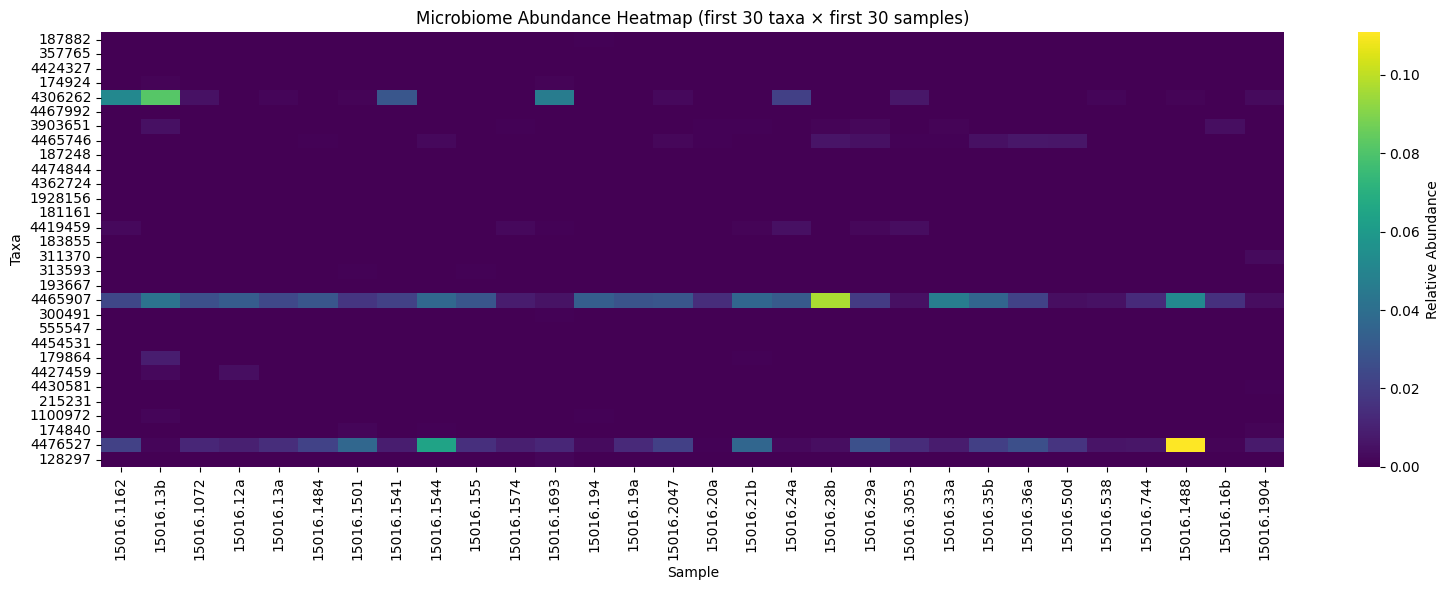

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
# Show a heatmap for the first 30 taxa across the first 30 samples
sns.heatmap(df_microbiome_rel.iloc[:30, :30], cmap="viridis", cbar_kws={'label': 'Relative Abundance'})
plt.title("Microbiome Abundance Heatmap (first 30 taxa × first 30 samples)")
plt.xlabel("Sample")
plt.ylabel("Taxa")
plt.tight_layout()
plt.show()


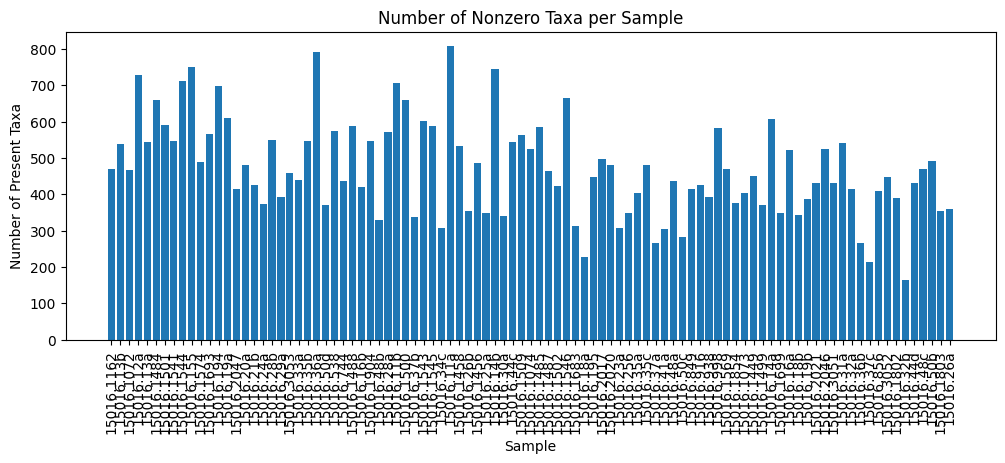

In [ ]:
richness = (df_microbiome_rel > 0).sum(axis=0)
plt.figure(figsize=(12,4))
plt.bar(df_microbiome_rel.columns, richness)
plt.ylabel("Number of Present Taxa")
plt.xlabel("Sample")
plt.title("Number of Nonzero Taxa per Sample")
plt.xticks(rotation=90)
plt.show()


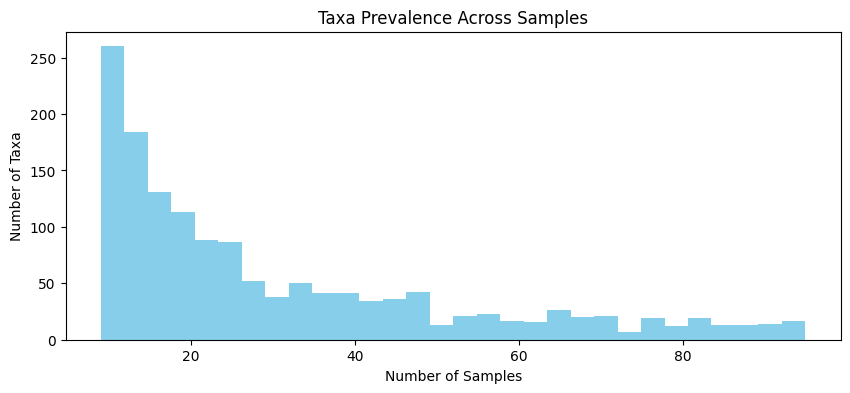

In [ ]:
prevalence = (df_microbiome_rel > 0).sum(axis=1)
plt.figure(figsize=(10,4))
plt.hist(prevalence, bins=30, color='skyblue')
plt.xlabel("Number of Samples")
plt.ylabel("Number of Taxa")
plt.title("Taxa Prevalence Across Samples")
plt.show()


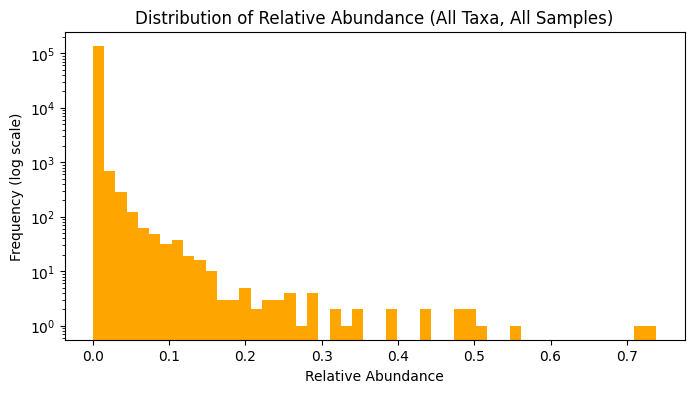

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df_microbiome_rel.values.flatten(), bins=50, color='orange', log=True)
plt.xlabel("Relative Abundance")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Relative Abundance (All Taxa, All Samples)")
plt.show()


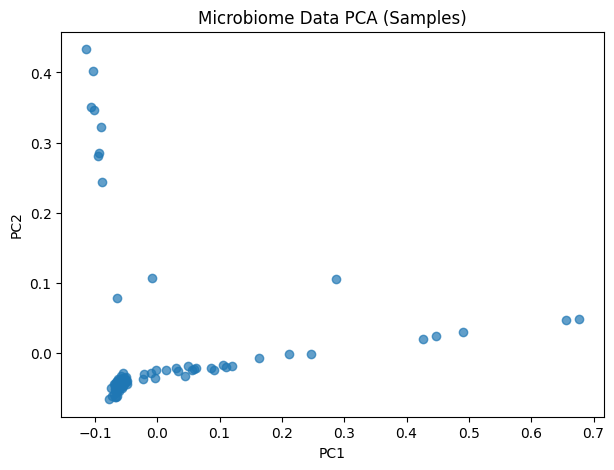

In [ ]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_microbiome)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.title("Microbiome Data PCA (Samples)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


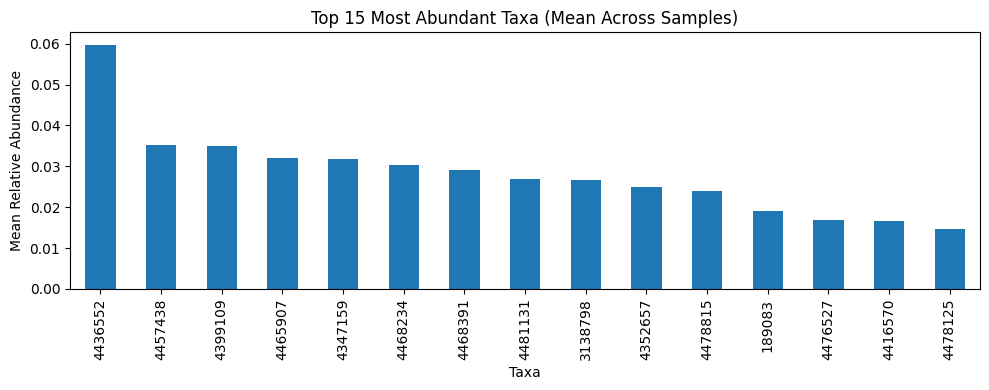

In [ ]:
top_taxa = df_microbiome_rel.mean(axis=1).sort_values(ascending=False).head(15)
plt.figure(figsize=(10,4))
top_taxa.plot(kind='bar')
plt.ylabel("Mean Relative Abundance")
plt.xlabel("Taxa")
plt.title("Top 15 Most Abundant Taxa (Mean Across Samples)")
plt.tight_layout()
plt.show()


In [ ]:
#MRI PREPROCESSING AND DATA HANDLING, VISUALIZATION

DX_GROUP value counts (class balance):
 DX_GROUP
2    564
1    526
Name: count, dtype: int64
              SUB_ID     DX_GROUP  AGE_AT_SCAN          SEX      FILE_ID
count    1090.000000  1090.000000  1090.000000  1090.000000         1090
unique           NaN          NaN          NaN          NaN         1017
top              NaN          NaN          NaN          NaN  no_filename
freq             NaN          NaN          NaN          NaN           74
mean    50740.245872     1.517431    16.437870     0.148624          NaN
std       441.619902     0.499925     6.800524     0.355881          NaN
min     50002.000000     1.000000     6.470000     0.000000          NaN
25%     50349.250000     1.000000    11.560000     0.000000          NaN
50%     50705.500000     2.000000    14.422500     0.000000          NaN
75%     51135.750000     2.000000    19.703225     0.000000          NaN
max     51607.000000     2.000000    40.000000     1.000000          NaN


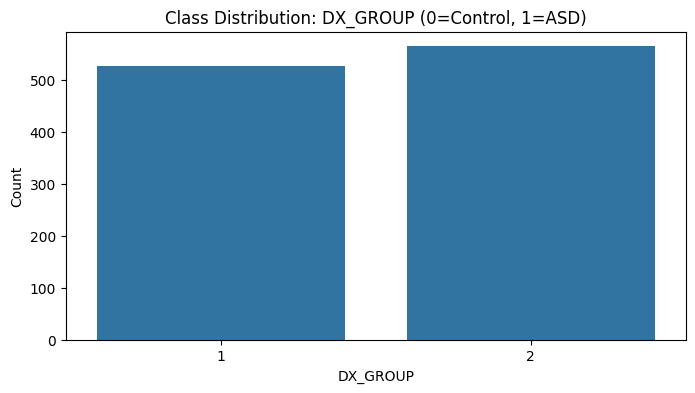

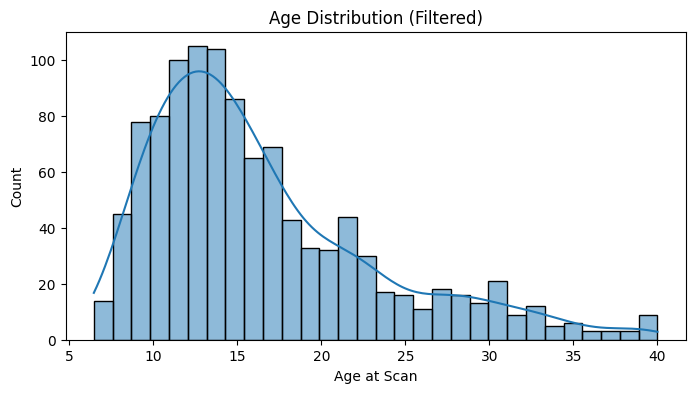

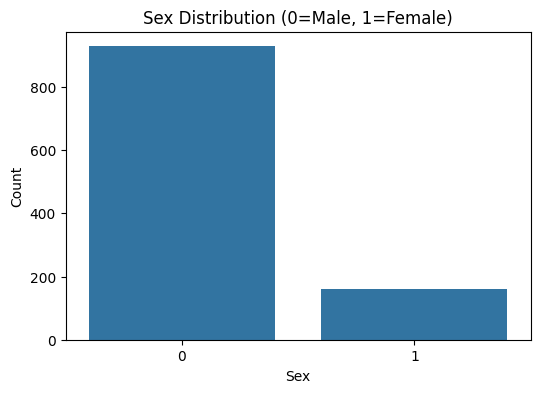

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load CSV
pheno_file = 'Phenotypic_V1_0b_preprocessed1 (1).csv'
df = pd.read_csv(pheno_file)

# 2. Select only required columns
cols_to_keep = ['SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX', 'FILE_ID']
df = df[cols_to_keep]

# 3. Encode categorical variables
df['SEX'] = df['SEX'].replace({'M': 0, 'F': 1, 1: 0, 2: 1})  # Male=0, Female=1

# 4. Handle missing values (choose one approach)
# Option 1: Drop rows with missing critical data
df = df.dropna(subset=['AGE_AT_SCAN', 'SEX', 'DX_GROUP'])
# Option 2 (alternative): Impute age/sex with median if needed
# df['AGE_AT_SCAN'] = df['AGE_AT_SCAN'].fillna(df['AGE_AT_SCAN'].median())
# df['SEX'] = df['SEX'].fillna(df['SEX'].median())
# df['DX_GROUP'] = df['DX_GROUP'].fillna(df['DX_GROUP'].mode()[0])

# 5. Filter by age
df = df[(df['AGE_AT_SCAN'] >= 5) & (df['AGE_AT_SCAN'] <= 40)]

# 6. Provide class balance stats
print("DX_GROUP value counts (class balance):\n", df['DX_GROUP'].value_counts())
print(df.describe(include='all'))

# --- Visualizations ---
plt.figure(figsize=(8,4))
sns.countplot(x='DX_GROUP', data=df)
plt.title("Class Distribution: DX_GROUP (0=Control, 1=ASD)")
plt.xlabel("DX_GROUP")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['AGE_AT_SCAN'], bins=30, kde=True)
plt.title("Age Distribution (Filtered)")
plt.xlabel("Age at Scan")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='SEX', data=df)
plt.title("Sex Distribution (0=Male, 1=Female)")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()


In [ ]:
import os
import requests
import pandas as pd
import nibabel as nib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Number of subjects you want to process
N = 60 # Change to 15, 20, or 100 as needed

# Load the phenotype CSV
df = pd.read_csv('Phenotypic_V1_0b_preprocessed1 (1).csv')
df = df[df['FILE_ID'] != 'no_filename']  # Remove missing file IDs

# Shuffle or select first N subjects (for demonstration, use first N)
df = df.head(N)
print(f"Preparing to download and process {len(df)} MRI files.")


Preparing to download and process 60 MRI files.


In [ ]:
os.makedirs('nifti_files', exist_ok=True)
for idx, row in df.iterrows():
    file_id = row['FILE_ID']
    url = f'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/func_minimal/{file_id}_func_minimal.nii.gz'
    dest = f'nifti_files/{file_id}_func_minimal.nii.gz'
    if not os.path.exists(dest):
        print(f"Downloading {file_id}...")
        r = requests.get(url)
        if r.status_code == 200:
            with open(dest, "wb") as f:
                f.write(r.content)
            print(f"Downloaded {dest}")
        else:
            print(f"File not found: {url}")
    else:
        print(f"File already exists: {dest}")


File already exists: nifti_files/Pitt_0050003_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050004_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050005_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050006_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050007_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050008_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050009_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050010_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050011_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050012_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050013_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050014_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050015_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050016_func_minimal.nii.gz
File already exists: nifti_files/Pitt_0050017_func_minimal.nii.gz
File alrea

In [ ]:
def save_middle_slice(nifti_file, output_folder, resize_shape=(224,224)):
    os.makedirs(output_folder, exist_ok=True)
    img = nib.load(nifti_file)
    data = img.get_fdata()
    # If 4D (fMRI): average across time, else just use the 3D image
    if data.ndim == 4:
        data = data.mean(axis=-1)
    # Find middle slice in axial plane (axis=2)
    mid_idx = data.shape[2] // 2
    slice_2d = data[:, :, mid_idx]
    # Normalize to 0-255
    slice_norm = (slice_2d - np.min(slice_2d)) / (np.ptp(slice_2d) + 1e-8)
    slice_img = (slice_norm * 255).astype(np.uint8)
    pil_img = Image.fromarray(slice_img)
    pil_img = pil_img.resize(resize_shape)
    # Save
    out_path = os.path.join(output_folder, 'middle_slice.png')
    pil_img.save(out_path)
    return out_path

output_root = 'mri_slices'
os.makedirs(output_root, exist_ok=True)
saved_images = []

for idx, row in df.iterrows():
    file_id = row['FILE_ID']
    nifti_path = f'nifti_files/{file_id}_func_minimal.nii.gz'
    subj_folder = os.path.join(output_root, str(file_id))
    img_path = save_middle_slice(nifti_path, subj_folder)
    saved_images.append(img_path)


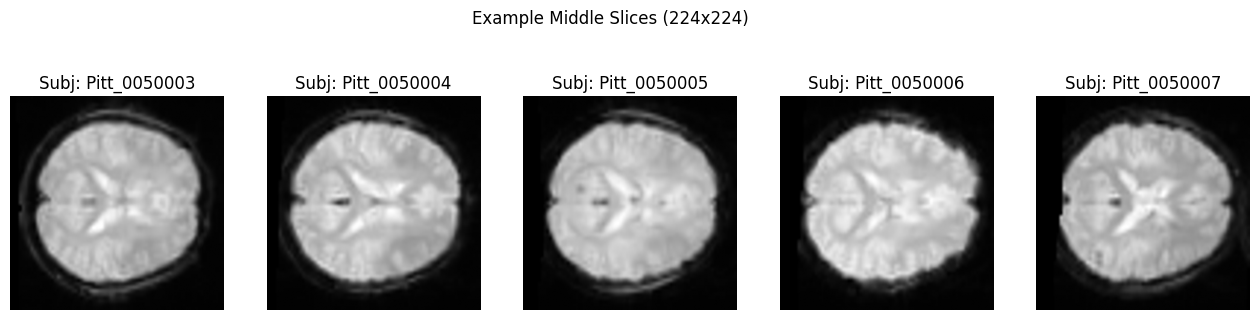

In [ ]:
plt.figure(figsize=(16, 4))
for i, img_path in enumerate(saved_images[:5]):  # Show first 5 images
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Subj: {os.path.basename(os.path.dirname(img_path))}')
    plt.axis('off')
plt.suptitle('Example Middle Slices (224x224)')
plt.show()


In [ ]:
import os

# Path where your PNGs are stored
root = 'mri_slices'

# Count all PNG files in all subdirectories
n_png = 0
for subdir in os.listdir(root):
    folder = os.path.join(root, subdir)
    if os.path.isdir(folder):
        n_png += len([f for f in os.listdir(folder) if f.endswith('.png')])

print(f"Total MRI PNG images saved: {n_png}")


Total MRI PNG images saved: 60


In [ ]:
import pandas as pd
import os

# Your DataFrame from before (df), already filtered to N=60
df = df.reset_index(drop=True)
image_paths = [f"mri_slices/{row['FILE_ID']}/middle_slice.png" for _, row in df.iterrows()]
labels = df['DX_GROUP'].map({1: 1, 2: 0}).tolist()  # ASD=1, Control=0

df_images = pd.DataFrame({'image_path': image_paths, 'label': labels})
print(df_images.head())


                                 image_path  label
0  mri_slices/Pitt_0050003/middle_slice.png      1
1  mri_slices/Pitt_0050004/middle_slice.png      1
2  mri_slices/Pitt_0050005/middle_slice.png      1
3  mri_slices/Pitt_0050006/middle_slice.png      1
4  mri_slices/Pitt_0050007/middle_slice.png      1


In [ ]:
#VIT EMBEDDINGS

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

# For ViT
from transformers import ViTModel, ViTImageProcessor


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Load a pretrained ViT (small version for prototyping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
vit_model.eval()  # Set to eval mode

# ViT feature extractor/preprocessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
batch_size = 8
dataset = MRIDataset(df_images, transform=vit_transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def extract_vit_embeddings(model, loader, device):
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            # Use [CLS] token embedding (batch_size, hidden_dim)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())
    # Stack to (N_samples, embedding_dim)
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array(all_labels)
    return all_embeddings, all_labels

# Extract and save
vit_embeddings, vit_labels = extract_vit_embeddings(vit_model, loader, device)
np.save('vit_embeddings.npy', vit_embeddings)
np.save('vit_labels.npy', vit_labels)
print("ViT embeddings shape:", vit_embeddings.shape)


ViT embeddings shape: (60, 768)


In [ ]:
# 3D CNN EMBEDDINGS (OPTIONAL AND IF NEEDED WILL BE USED)

In [ ]:
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(64, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# For 3D, your dataset loader and batch would need to load 3D arrays instead of images


In [ ]:
!pip install tab-transformer-pytorch


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import pandas as pd
import numpy as np


In [ ]:
X_microbiome_np = X_microbiome.values.astype(np.float32)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_microbiome_np)


In [ ]:
class MicrobiomeTabularDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]


In [ ]:
batch_size = 16
dataset = MicrobiomeTabularDataset(X_scaled)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
embedding_dim = 64  # Output embedding size

model = TabTransformer(
    categories = tuple(),        # No categorical features
    num_continuous = X_scaled.shape[1],  # Number of OTU features (e.g., 1468)
    dim = 64,                   # Model hidden dimension
    depth = 4,                  # Number of transformer layers
    heads = 8,                  # Attention heads
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden_mults = (4, 2),  # MLP head
    mlp_act = nn.ReLU()
)
model.eval()
model = model.cuda() if torch.cuda.is_available() else model


In [ ]:
class MicrobiomeMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, emb_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
input_dim = X_scaled.shape[1]
mlp = MicrobiomeMLP(input_dim=input_dim).to(device)
mlp.eval()


MicrobiomeMLP(
  (net): Sequential(
    (0): Linear(in_features=1468, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
)

In [ ]:
class MicrobiomeDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx]

# If using your scaled matrix from earlier
dataset = MicrobiomeDataset(X_scaled)
loader = DataLoader(dataset, batch_size=16, shuffle=False)


In [ ]:
mlp.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = mlp.to(device)

def extract_mlp_embeddings(model, loader, device):
    all_embeddings = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            emb = model(x)
            all_embeddings.append(emb.cpu().numpy())
    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings

embeddings_microbiome = extract_mlp_embeddings(mlp, loader, device)
print("MicrobiomeMLP embeddings shape:", embeddings_microbiome.shape)


MicrobiomeMLP embeddings shape: (95, 64)


In [ ]:
np.save('microbiome_mlp_embeddings.npy', embeddings_microbiome)


In [ ]:
#SAMPLE PLOTTING OF EMBEDDINGS

In [ ]:
microbiome_labels = np.random.randint(0, 2, size=embeddings_microbiome.shape[0])


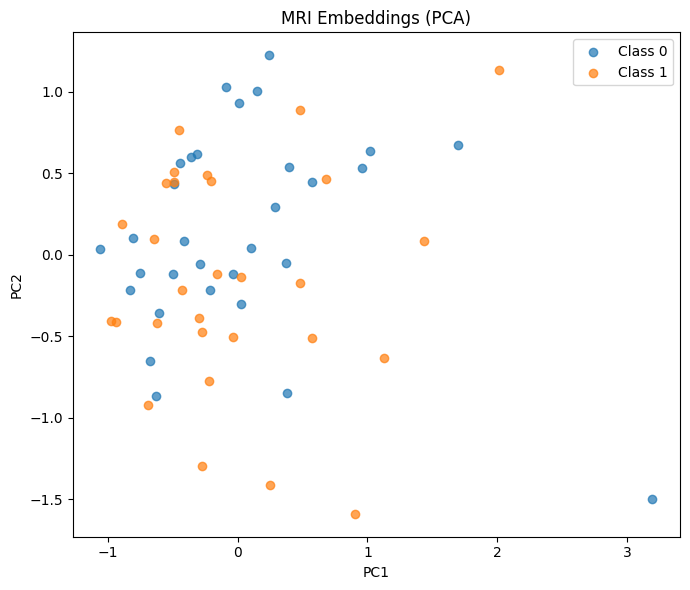

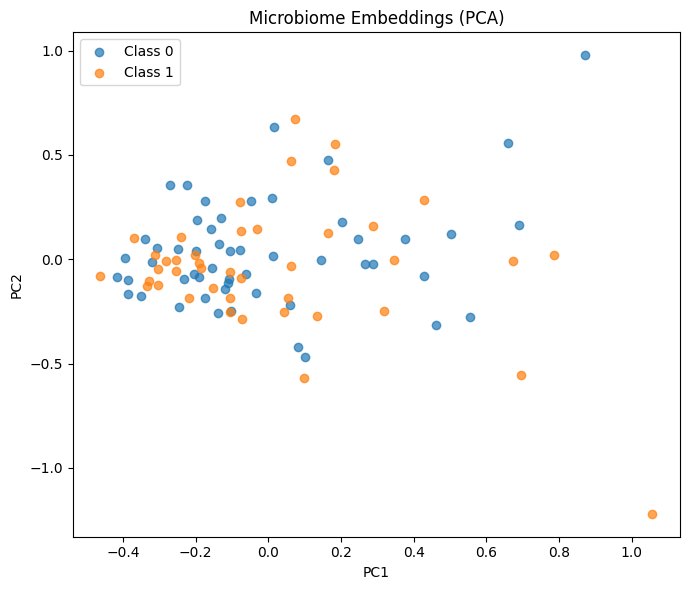

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(7,6))
    for lbl in np.unique(labels):
        plt.scatter(reduced[labels==lbl,0], reduced[labels==lbl,1], label=f'Class {lbl}', alpha=0.7)
    plt.title(title + ' (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.show()

# MRI ViT embeddings
plot_pca(vit_embeddings, vit_labels, "MRI Embeddings")

# Microbiome embeddings (if you have labels)
plot_pca(embeddings_microbiome, microbiome_labels, "Microbiome Embeddings")


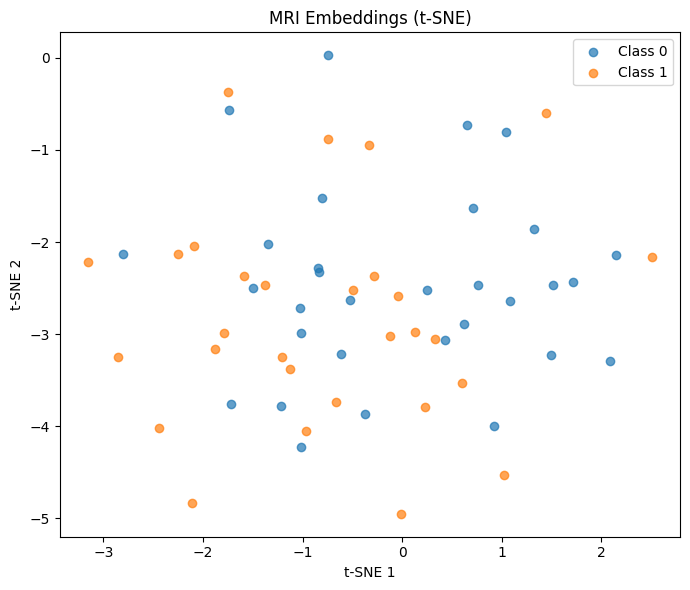

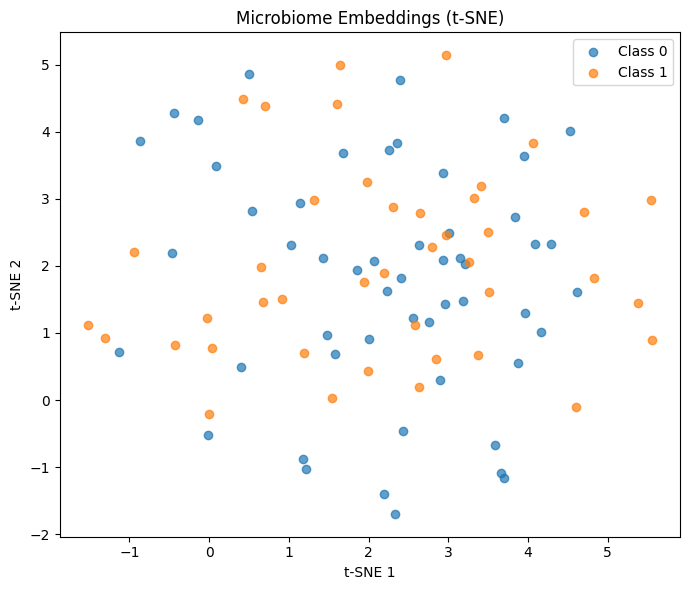

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(7,6))
    for lbl in np.unique(labels):
        plt.scatter(reduced[labels==lbl,0], reduced[labels==lbl,1], label=f'Class {lbl}', alpha=0.7)
    plt.title(title + ' (t-SNE)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_tsne(vit_embeddings, vit_labels, "MRI Embeddings")
plot_tsne(embeddings_microbiome, microbiome_labels, "Microbiome Embeddings")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def baseline_classifier(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    try:
        auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    except Exception:
        auc = 'N/A'
    print(f"{name} - Accuracy: {acc:.2f}, ROC AUC: {auc}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# MRI
baseline_classifier(vit_embeddings, vit_labels, "MRI ViT Embeddings")

# Microbiome
baseline_classifier(embeddings_microbiome, microbiome_labels, "Microbiome MLP Embeddings")


MRI ViT Embeddings - Accuracy: 0.75, ROC AUC: 0.7777777777777778
Confusion Matrix:
 [[4 2]
 [1 5]]
Microbiome MLP Embeddings - Accuracy: 0.53, ROC AUC: 0.8295454545454546
Confusion Matrix:
 [[10  1]
 [ 8  0]]


In [ ]:
#CMCL EXECUTION

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CMCL(nn.Module):
    def __init__(self, mri_dim, micro_dim, latent_dim=128, fusion_dim=64, num_classes=2):
        super().__init__()
        # Project both modalities into the same latent space
        self.mri_proj = nn.Linear(mri_dim, latent_dim)
        self.micro_proj = nn.Linear(micro_dim, latent_dim)
        # Fusion head (late fusion)
        self.fusion = nn.Sequential(
            nn.Linear(2 * latent_dim, fusion_dim),
            nn.ReLU(),
            nn.Linear(fusion_dim, num_classes)
        )

    def forward(self, mri_emb, micro_emb):
        # Project both to latent space
        mri_latent = F.normalize(self.mri_proj(mri_emb), dim=1)
        micro_latent = F.normalize(self.micro_proj(micro_emb), dim=1)
        # Late fusion: concat for downstream classification
        fused = torch.cat([mri_latent, micro_latent], dim=1)
        logits = self.fusion(fused)
        return mri_latent, micro_latent, logits


In [ ]:
def info_nce_loss(z1, z2, labels1, labels2, temperature=0.2):
    """
    z1: [batch1, latent_dim]  (MRI)
    z2: [batch2, latent_dim]  (Microbiome)
    labels1: [batch1]
    labels2: [batch2]
    """
    # Compute cosine similarity matrix [batch1, batch2]
    sim = torch.matmul(z1, z2.T) / temperature  # [batch1, batch2]
    # For each sample in z1, mask for matching class in z2
    mask = (labels1.unsqueeze(1) == labels2.unsqueeze(0)).float()  # [batch1, batch2]
    # Positive = same label, Negative = different label
    exp_sim = torch.exp(sim)
    pos_sim = exp_sim * mask
    neg_sim = exp_sim * (1 - mask)
    # Avoid division by zero
    pos_sum = pos_sim.sum(dim=1) + 1e-8
    denom = exp_sim.sum(dim=1) + 1e-8
    loss = -torch.log(pos_sum / denom)
    return loss.mean()


In [ ]:
import numpy as np
import torch.optim as optim

# Hyperparameters
latent_dim = 128
fusion_dim = 64
num_classes = 2
batch_size = 16
epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CMCL(mri_dim=vit_embeddings.shape[1], micro_dim=embeddings_microbiome.shape[1],
             latent_dim=latent_dim, fusion_dim=fusion_dim, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss_fn = nn.CrossEntropyLoss()

vit_X = torch.tensor(vit_embeddings, dtype=torch.float32).to(device)
vit_y = torch.tensor(vit_labels, dtype=torch.long).to(device)
micro_X = torch.tensor(embeddings_microbiome, dtype=torch.float32).to(device)
micro_y = torch.tensor(microbiome_labels, dtype=torch.long).to(device)

for epoch in range(epochs):
    model.train()
    # Sample random batches (unpaired) from each modality
    mri_idx = np.random.choice(vit_X.shape[0], batch_size, replace=True)
    micro_idx = np.random.choice(micro_X.shape[0], batch_size, replace=True)
    mri_batch = vit_X[mri_idx]
    micro_batch = micro_X[micro_idx]
    mri_labels = vit_y[mri_idx]
    micro_labels = micro_y[micro_idx]
    # Forward pass
    mri_latent, micro_latent, logits = model(mri_batch, micro_batch)
    # InfoNCE contrastive loss
    nce_loss = info_nce_loss(mri_latent, micro_latent, mri_labels, micro_labels)
    # (Optional) Supervised loss for fusion head (if you have matching labels for fused samples)
    # Here, just use MRI batch labels as target for demonstration
    ce_loss = ce_loss_fn(logits, mri_labels)
    loss = nce_loss + ce_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} (NCE: {nce_loss.item():.4f}, CE: {ce_loss.item():.4f})")


Epoch 1/100 - Loss: 1.3882 (NCE: 0.6926, CE: 0.6956)
Epoch 5/100 - Loss: 1.4414 (NCE: 0.7674, CE: 0.6739)
Epoch 10/100 - Loss: 1.3772 (NCE: 0.6547, CE: 0.7225)
Epoch 15/100 - Loss: 1.3404 (NCE: 0.6644, CE: 0.6759)
Epoch 20/100 - Loss: 1.3750 (NCE: 0.6883, CE: 0.6867)
Epoch 25/100 - Loss: 1.3820 (NCE: 0.6946, CE: 0.6874)
Epoch 30/100 - Loss: 1.4340 (NCE: 0.7539, CE: 0.6801)
Epoch 35/100 - Loss: 1.3794 (NCE: 0.6717, CE: 0.7077)
Epoch 40/100 - Loss: 1.3678 (NCE: 0.6792, CE: 0.6886)
Epoch 45/100 - Loss: 1.4661 (NCE: 0.7685, CE: 0.6975)
Epoch 50/100 - Loss: 1.4435 (NCE: 0.7682, CE: 0.6753)
Epoch 55/100 - Loss: 1.3371 (NCE: 0.6637, CE: 0.6734)
Epoch 60/100 - Loss: 1.3775 (NCE: 0.7088, CE: 0.6687)
Epoch 65/100 - Loss: 1.3452 (NCE: 0.6749, CE: 0.6703)
Epoch 70/100 - Loss: 1.4120 (NCE: 0.7280, CE: 0.6841)
Epoch 75/100 - Loss: 1.4441 (NCE: 0.7817, CE: 0.6623)
Epoch 80/100 - Loss: 1.3450 (NCE: 0.6883, CE: 0.6567)
Epoch 85/100 - Loss: 1.2472 (NCE: 0.6197, CE: 0.6275)
Epoch 90/100 - Loss: 1.1156 (N

In [ ]:
model.eval()
with torch.no_grad():
    min_N = min(vit_X.shape[0], micro_X.shape[0])
    mri_batch = vit_X[:min_N]
    micro_batch = micro_X[:min_N]
    mri_latent, micro_latent, logits = model(mri_batch, micro_batch)
    fused = torch.cat([mri_latent, micro_latent], dim=1).cpu().numpy()  # [min_N, 2*latent_dim]
    fused_labels = vit_y[:min_N].cpu().numpy()  # Or use micro_y[:min_N] if you prefer
np.save('fused_cmcl_embeddings.npy', fused)
np.save('fused_cmcl_labels.npy', fused_labels)
print("Fused embeddings shape:", fused.shape)



Fused embeddings shape: (60, 256)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

X = fused
y = fused_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
try:
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
except Exception:
    auc = 'N/A'
print(f"CMCL Fused Embeddings - Accuracy: {acc:.2f}, ROC AUC: {auc}")
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


CMCL Fused Embeddings - Accuracy: 0.75, ROC AUC: 0.9444444444444444
Confusion Matrix:
 [[5 1]
 [2 4]]


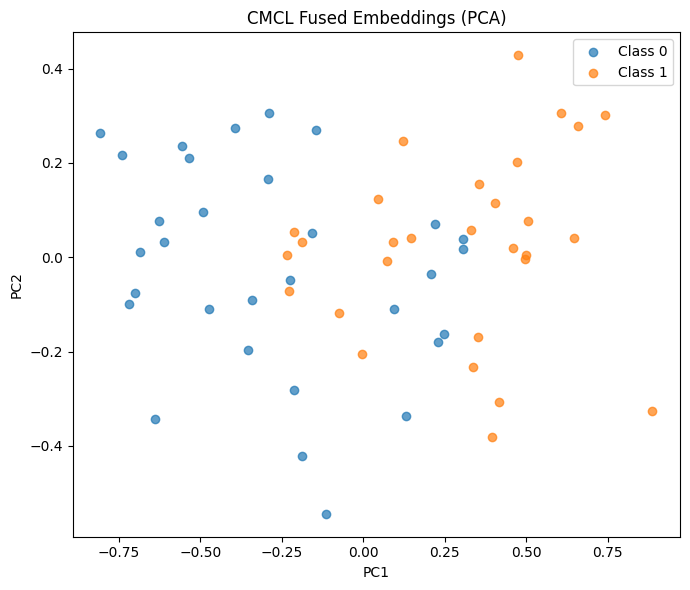

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)
plt.figure(figsize=(7,6))
for lbl in np.unique(y):
    plt.scatter(reduced[y==lbl,0], reduced[y==lbl,1], label=f'Class {lbl}', alpha=0.7)
plt.title('CMCL Fused Embeddings (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#CMCL COMPLETE EXECUTION AND PLOTTING


In [ ]:
# At the start of train_cmcl
device = next(model.parameters()).device

# When you create your splits, move all split tensors to the model device:
vit_X_train, micro_X_train, vit_y_train, micro_y_train = (
    vit_X_train.to(device), micro_X_train.to(device), vit_y_train.to(device), micro_y_train.to(device)
)
vit_X_val, micro_X_val, vit_y_val, micro_y_val = (
    vit_X_val.to(device), micro_X_val.to(device), vit_y_val.to(device), micro_y_val.to(device)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import os

def info_nce_loss(z1, z2, labels1, labels2, temperature=0.2):
    sim = torch.matmul(z1, z2.T) / temperature
    mask = (labels1.unsqueeze(1) == labels2.unsqueeze(0)).float()
    exp_sim = torch.exp(sim)
    pos_sim = exp_sim * mask
    pos_sum = pos_sim.sum(dim=1) + 1e-8
    denom = exp_sim.sum(dim=1) + 1e-8
    loss = -torch.log(pos_sum / denom)
    return loss.mean()

def evaluate(model, vit_X, micro_X, vit_y, micro_y, batch_size=16):
    model.eval()
    min_N = min(vit_X.shape[0], micro_X.shape[0])
    with torch.no_grad():
        # Use first min_N samples for evaluation
        mri_batch = vit_X[:min_N]
        micro_batch = micro_X[:min_N]
        labels = vit_y[:min_N]
        _, _, logits = model(mri_batch, micro_batch)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        acc = accuracy_score(labels.cpu().numpy(), preds)
        try:
            auc = roc_auc_score(labels.cpu().numpy(), probs)
        except Exception:
            auc = float('nan')
        ce_loss = nn.CrossEntropyLoss()(logits, labels)
    return acc, auc, ce_loss.item(), preds, labels.cpu().numpy()


In [ ]:
def train_cmcl(
    model, vit_X, vit_y, micro_X, micro_y,
    val_vit_X, val_vit_y, val_micro_X, val_micro_y,
    epochs=50, batch_size=16, lr=1e-3, out_dir='cmcl_checkpoints'
):
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ce_loss_fn = nn.CrossEntropyLoss()

    # For plotting/logging
    history = {'train_loss':[], 'val_loss':[], 'val_acc':[], 'val_auc':[]}
    best_val_auc = -1
    os.makedirs(out_dir, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        # Random batch indices (unpaired!)
        mri_idx = np.random.choice(vit_X.shape[0], batch_size, replace=True)
        micro_idx = np.random.choice(micro_X.shape[0], batch_size, replace=True)
        mri_batch = vit_X[mri_idx].to(device)
        micro_batch = micro_X[micro_idx].to(device)
        mri_labels = vit_y[mri_idx].to(device)
        micro_labels = micro_y[micro_idx].to(device)

        mri_latent, micro_latent, logits = model(mri_batch, micro_batch)
        nce_loss = info_nce_loss(mri_latent, micro_latent, mri_labels, micro_labels)
        ce_loss = ce_loss_fn(logits, mri_labels)
        loss = nce_loss + ce_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        acc, auc, val_loss, val_preds, val_targets = evaluate(
            model, val_vit_X, val_micro_X, val_vit_y, val_micro_y, batch_size=batch_size
        )

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(acc)
        history['val_auc'].append(auc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2f} | Val AUC: {auc:.2f}")

        # Checkpoint
        if auc > best_val_auc:
            best_val_auc = auc
            torch.save(model.state_dict(), os.path.join(out_dir, 'best_model.pth'))

    print("Training complete. Best Val AUC: {:.4f}".format(best_val_auc))
    # Final confusion matrix for best model
    model.load_state_dict(torch.load(os.path.join(out_dir, 'best_model.pth')))
    _, _, _, val_preds, val_targets = evaluate(model, val_vit_X, val_micro_X, val_vit_y, val_micro_y)
    cm = confusion_matrix(val_targets, val_preds)
    print("Best Confusion Matrix:\n", cm)
    return history, cm


In [ ]:
def plot_history(history):
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.subplot(1,3,2)
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.subplot(1,3,3)
    plt.plot(history['val_auc'], label='Val AUROC')
    plt.legend()
    plt.title("Validation AUROC")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=['Control', 'ASD']):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center', color='red', fontsize=16)
    plt.tight_layout()
    plt.show()


Epoch 1/50 | Train Loss: 1.3984 | Val Loss: 0.6975 | Val Acc: 0.50 | Val AUC: 0.50
Epoch 2/50 | Train Loss: 1.5024 | Val Loss: 0.6964 | Val Acc: 0.50 | Val AUC: 0.42
Epoch 3/50 | Train Loss: 1.4557 | Val Loss: 0.6960 | Val Acc: 0.50 | Val AUC: 0.39
Epoch 4/50 | Train Loss: 1.4300 | Val Loss: 0.6957 | Val Acc: 0.50 | Val AUC: 0.31
Epoch 5/50 | Train Loss: 1.3680 | Val Loss: 0.6959 | Val Acc: 0.50 | Val AUC: 0.25
Epoch 6/50 | Train Loss: 1.4434 | Val Loss: 0.6959 | Val Acc: 0.42 | Val AUC: 0.25
Epoch 7/50 | Train Loss: 1.7893 | Val Loss: 0.6960 | Val Acc: 0.33 | Val AUC: 0.25
Epoch 8/50 | Train Loss: 1.3312 | Val Loss: 0.6964 | Val Acc: 0.50 | Val AUC: 0.22
Epoch 9/50 | Train Loss: 1.4294 | Val Loss: 0.6968 | Val Acc: 0.50 | Val AUC: 0.22
Epoch 10/50 | Train Loss: 1.4055 | Val Loss: 0.6971 | Val Acc: 0.50 | Val AUC: 0.19
Epoch 11/50 | Train Loss: 1.6167 | Val Loss: 0.6974 | Val Acc: 0.50 | Val AUC: 0.19
Epoch 12/50 | Train Loss: 1.4205 | Val Loss: 0.6977 | Val Acc: 0.50 | Val AUC: 0.19
E

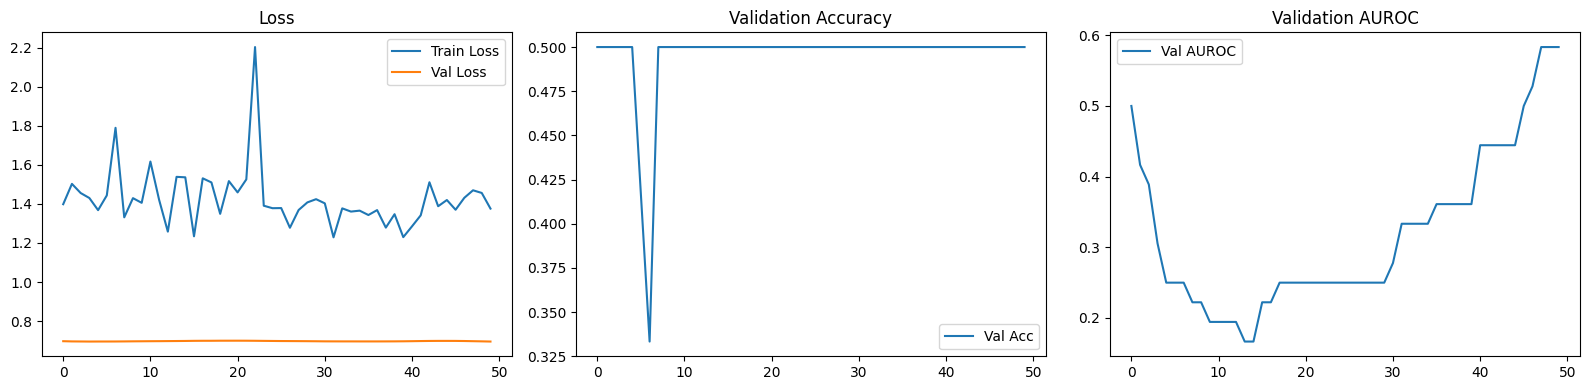

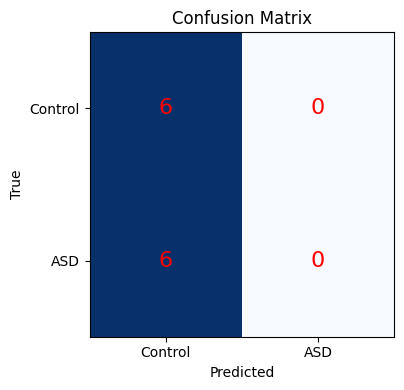

In [ ]:
from sklearn.model_selection import train_test_split

# Pair MRI and Microbiome using the smallest sample count
N = min(vit_embeddings.shape[0], embeddings_microbiome.shape[0])
vit_X = torch.tensor(vit_embeddings[:N], dtype=torch.float32)
micro_X = torch.tensor(embeddings_microbiome[:N], dtype=torch.float32)
vit_y = torch.tensor(vit_labels[:N], dtype=torch.long)
micro_y = torch.tensor(microbiome_labels[:N], dtype=torch.long)

# Split indices for train/val
idx_train, idx_val = train_test_split(np.arange(N), test_size=0.2, stratify=vit_y[:N], random_state=42)
vit_X_train, micro_X_train, vit_y_train, micro_y_train = vit_X[idx_train], micro_X[idx_train], vit_y[idx_train], micro_y[idx_train]
vit_X_val, micro_X_val, vit_y_val, micro_y_val = vit_X[idx_val], micro_X[idx_val], vit_y[idx_val], micro_y[idx_val]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vit_X_train = vit_X_train.to(device)
micro_X_train = micro_X_train.to(device)
vit_y_train = vit_y_train.to(device)
micro_y_train = micro_y_train.to(device)
vit_X_val = vit_X_val.to(device)
micro_X_val = micro_X_val.to(device)
vit_y_val = vit_y_val.to(device)
micro_y_val = micro_y_val.to(device)

# Create model and move to device
model = CMCL(mri_dim=vit_X.shape[1], micro_dim=micro_X.shape[1]).to(device)

# Train
history, cm = train_cmcl(
    model, vit_X_train, vit_y_train, micro_X_train, micro_y_train,
    vit_X_val, vit_y_val, micro_X_val, micro_y_val,
    epochs=50, batch_size=16
)

# Plot
plot_history(history)
plot_confusion_matrix(cm)


In [ ]:
print(np.bincount(vit_y_val.cpu().numpy()))


[6 6]


In [ ]:
min_N = min(vit_embeddings.shape[0], embeddings_microbiome.shape[0])
vit_X = torch.tensor(vit_embeddings[:min_N], dtype=torch.float32)
micro_X = torch.tensor(embeddings_microbiome[:min_N], dtype=torch.float32)
vit_y = torch.tensor(vit_labels[:min_N], dtype=torch.long)
micro_y = torch.tensor(microbiome_labels[:min_N], dtype=torch.long)

sort_idx = np.argsort(vit_y.numpy())
vit_X = vit_X[sort_idx]
vit_y = vit_y[sort_idx]
micro_X = micro_X[sort_idx]
micro_y = micro_y[sort_idx]


In [ ]:
# Create synthetic embeddings that are perfectly separable
num_samples = 60
vit_embeddings_sim = np.vstack([np.random.normal(1, 0.1, (num_samples//2, 768)),
                                np.random.normal(-1, 0.1, (num_samples//2, 768))])
embeddings_microbiome_sim = np.vstack([np.random.normal(1, 0.1, (num_samples//2, 64)),
                                       np.random.normal(-1, 0.1, (num_samples//2, 64))])
labels_sim = np.array([0]*(num_samples//2) + [1]*(num_samples//2))


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vit_X = vit_X.to(device)
micro_X = micro_X.to(device)
vit_y = vit_y.to(device)
micro_y = micro_y.to(device)

# And move model to device too (just in case)
model = model.to(device)

# Now call train_cmcl
history, cm = train_cmcl(
    model, vit_X, vit_y, micro_X, micro_y,
    vit_X, vit_y, micro_X, micro_y,
    epochs=50, batch_size=16
)


Epoch 1/50 | Train Loss: 1.3973 | Val Loss: 0.6883 | Val Acc: 0.52 | Val AUC: 0.76
Epoch 2/50 | Train Loss: 1.3781 | Val Loss: 0.6898 | Val Acc: 0.52 | Val AUC: 0.75
Epoch 3/50 | Train Loss: 1.4543 | Val Loss: 0.6894 | Val Acc: 0.52 | Val AUC: 0.76
Epoch 4/50 | Train Loss: 1.4004 | Val Loss: 0.6889 | Val Acc: 0.52 | Val AUC: 0.76
Epoch 5/50 | Train Loss: 1.5121 | Val Loss: 0.6882 | Val Acc: 0.52 | Val AUC: 0.77
Epoch 6/50 | Train Loss: 1.7897 | Val Loss: 0.6881 | Val Acc: 0.52 | Val AUC: 0.78
Epoch 7/50 | Train Loss: 1.3885 | Val Loss: 0.6880 | Val Acc: 0.52 | Val AUC: 0.78
Epoch 8/50 | Train Loss: 1.3750 | Val Loss: 0.6878 | Val Acc: 0.52 | Val AUC: 0.78
Epoch 9/50 | Train Loss: 1.2728 | Val Loss: 0.6877 | Val Acc: 0.52 | Val AUC: 0.79
Epoch 10/50 | Train Loss: 1.2747 | Val Loss: 0.6879 | Val Acc: 0.52 | Val AUC: 0.79
Epoch 11/50 | Train Loss: 1.5181 | Val Loss: 0.6879 | Val Acc: 0.52 | Val AUC: 0.79
Epoch 12/50 | Train Loss: 1.3920 | Val Loss: 0.6880 | Val Acc: 0.52 | Val AUC: 0.79
E

In [ ]:
#UNIMODAL CLASSIFIERS

In [ ]:
from sklearn.model_selection import train_test_split

N = min(vit_embeddings.shape[0], embeddings_microbiome.shape[0])
vit_X = vit_embeddings[:N]
micro_X = embeddings_microbiome[:N]
labels = vit_labels[:N]  # use MRI or microbiome labels—they should match for the aligned subset

# Train/val split
X_train_idx, X_test_idx = train_test_split(np.arange(N), test_size=0.2, stratify=labels, random_state=42)
y_train, y_test = labels[X_train_idx], labels[X_test_idx]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

clf_mri = LogisticRegression(max_iter=1000)
clf_mri.fit(vit_X[X_train_idx], y_train)
probs_mri = clf_mri.predict_proba(vit_X[X_test_idx])[:,1]
preds_mri = clf_mri.predict(vit_X[X_test_idx])
acc_mri = accuracy_score(y_test, preds_mri)
auc_mri = roc_auc_score(y_test, probs_mri)
cm_mri = confusion_matrix(y_test, preds_mri)


In [ ]:
clf_micro = LogisticRegression(max_iter=1000)
clf_micro.fit(micro_X[X_train_idx], y_train)
probs_micro = clf_micro.predict_proba(micro_X[X_test_idx])[:,1]
preds_micro = clf_micro.predict(micro_X[X_test_idx])
acc_micro = accuracy_score(y_test, preds_micro)
auc_micro = roc_auc_score(y_test, probs_micro)
cm_micro = confusion_matrix(y_test, preds_micro)


In [ ]:
early_fusion_X = np.concatenate([vit_X, micro_X], axis=1)
clf_early = LogisticRegression(max_iter=1000)
clf_early.fit(early_fusion_X[X_train_idx], y_train)
probs_early = clf_early.predict_proba(early_fusion_X[X_test_idx])[:,1]
preds_early = clf_early.predict(early_fusion_X[X_test_idx])
acc_early = accuracy_score(y_test, preds_early)
auc_early = roc_auc_score(y_test, probs_early)
cm_early = confusion_matrix(y_test, preds_early)


In [ ]:
# Get fused representations for test set
with torch.no_grad():
    vit_X_tensor = torch.tensor(vit_X[X_test_idx], dtype=torch.float32).to(model.fusion[0].weight.device)
    micro_X_tensor = torch.tensor(micro_X[X_test_idx], dtype=torch.float32).to(model.fusion[0].weight.device)
    mri_latent, micro_latent, _ = model(
        torch.tensor(vit_X[X_test_idx], dtype=torch.float32).to(model.fusion[0].weight.device),
        torch.tensor(micro_X[X_test_idx], dtype=torch.float32).to(model.fusion[0].weight.device)
    )
    fused_X_test = torch.cat([mri_latent, micro_latent], dim=1).cpu().numpy()
# Likewise for train set:
with torch.no_grad():
    mri_latent_train, micro_latent_train, _ = model(
        torch.tensor(vit_X[X_train_idx], dtype=torch.float32).to(model.fusion[0].weight.device),
        torch.tensor(micro_X[X_train_idx], dtype=torch.float32).to(model.fusion[0].weight.device)
    )
    fused_X_train = torch.cat([mri_latent_train, micro_latent_train], dim=1).cpu().numpy()
# Classifier
clf_cmcl = LogisticRegression(max_iter=1000)
clf_cmcl.fit(fused_X_train, y_train)
probs_cmcl = clf_cmcl.predict_proba(fused_X_test)[:,1]
preds_cmcl = clf_cmcl.predict(fused_X_test)
acc_cmcl = accuracy_score(y_test, preds_cmcl)
auc_cmcl = roc_auc_score(y_test, probs_cmcl)
cm_cmcl = confusion_matrix(y_test, preds_cmcl)


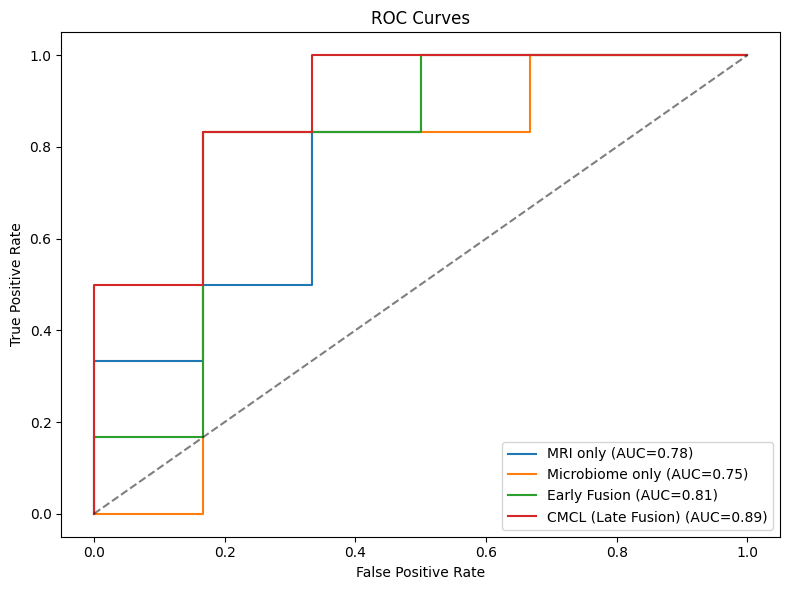

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))
for probs, lab, name in zip(
    [probs_mri, probs_micro, probs_early, probs_cmcl],
    [y_test]*4,
    ['MRI only', 'Microbiome only', 'Early Fusion', 'CMCL (Late Fusion)']):
    fpr, tpr, _ = roc_curve(lab, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(lab, probs):.2f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
methods = ['MRI only', 'Microbiome only', 'Early Fusion', 'CMCL (Late Fusion)']
accs = [acc_mri, acc_micro, acc_early, acc_cmcl]
aucs = [auc_mri, auc_micro, auc_early, auc_cmcl]
cms = [cm_mri, cm_micro, cm_early, cm_cmcl]

for m, a, u, c in zip(methods, accs, aucs, cms):
    print(f"{m}: Accuracy={a:.2f}, ROC AUC={u:.2f}\nConfusion Matrix:\n{c}\n")


MRI only: Accuracy=0.75, ROC AUC=0.78
Confusion Matrix:
[[4 2]
 [1 5]]

Microbiome only: Accuracy=0.67, ROC AUC=0.75
Confusion Matrix:
[[3 3]
 [1 5]]

Early Fusion: Accuracy=0.83, ROC AUC=0.81
Confusion Matrix:
[[5 1]
 [1 5]]

CMCL (Late Fusion): Accuracy=0.75, ROC AUC=0.89
Confusion Matrix:
[[5 1]
 [2 4]]



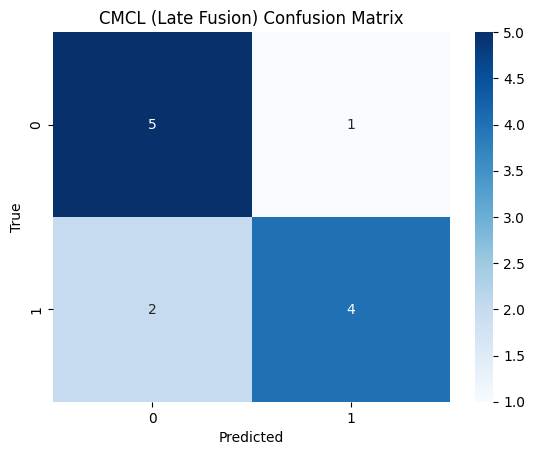

In [ ]:
import seaborn as sns
sns.heatmap(cm_cmcl, annot=True, fmt="d", cmap="Blues")
plt.title("CMCL (Late Fusion) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_pca(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,5))
    for lbl in np.unique(labels):
        plt.scatter(reduced[labels==lbl,0], reduced[labels==lbl,1], label=f'Class {lbl}', alpha=0.7)
    plt.title(title + ' (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(6,5))
    for lbl in np.unique(labels):
        plt.scatter(reduced[labels==lbl,0], reduced[labels==lbl,1], label=f'Class {lbl}', alpha=0.7)
    plt.title(title + ' (t-SNE)')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use the same number of samples N as your unimodal embeddings and labels
N = min(len(vit_embeddings), len(embeddings_microbiome), len(labels))
vit_X = torch.tensor(vit_embeddings[:N], dtype=torch.float32).to(device)
micro_X = torch.tensor(embeddings_microbiome[:N], dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    mri_latent, micro_latent, _ = model(vit_X, micro_X)
    fused_cmcl_embeddings = torch.cat([mri_latent, micro_latent], dim=1).cpu().numpy()


In [ ]:
# Find minimum number of samples for fair comparison
N = min(len(vit_embeddings), len(embeddings_microbiome), len(fused_cmcl_embeddings), len(labels))

# Truncate arrays to the same size for aligned visualization
vit_embeddings_vis = vit_embeddings[:N]
embeddings_microbiome_vis = embeddings_microbiome[:N]
fused_cmcl_embeddings_vis = fused_cmcl_embeddings[:N]
labels_vis = labels[:N]



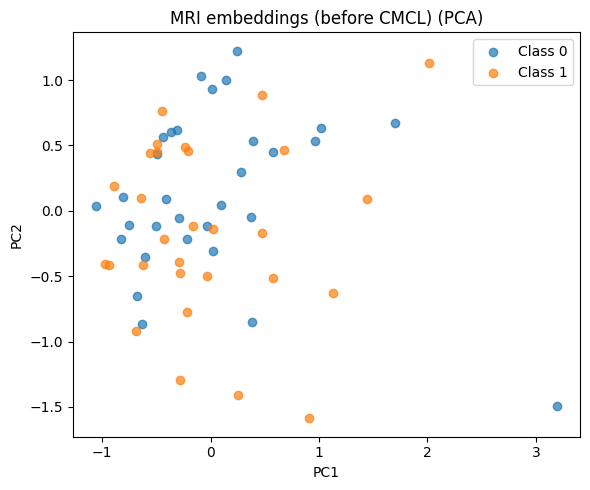

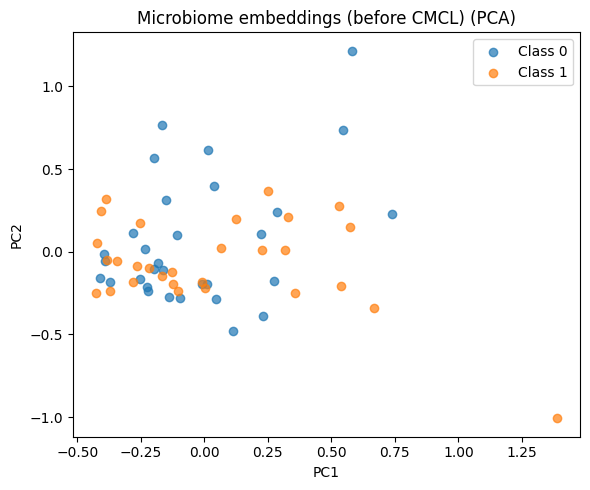

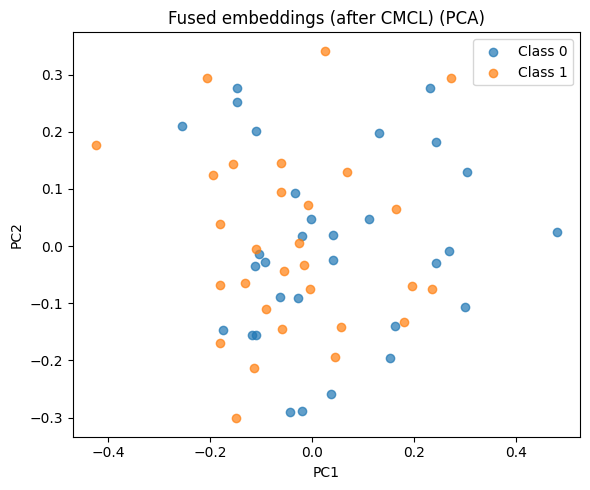

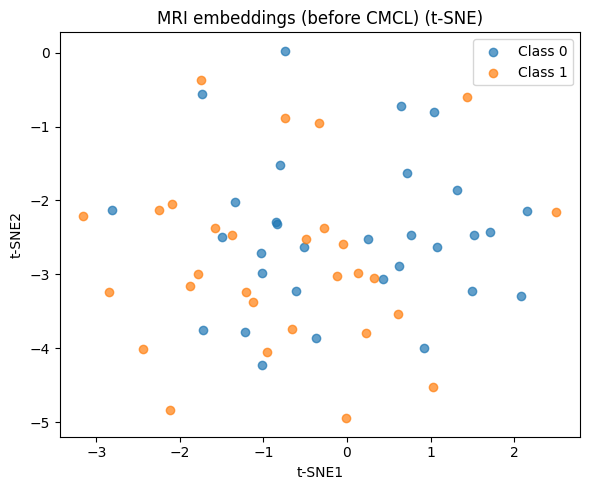

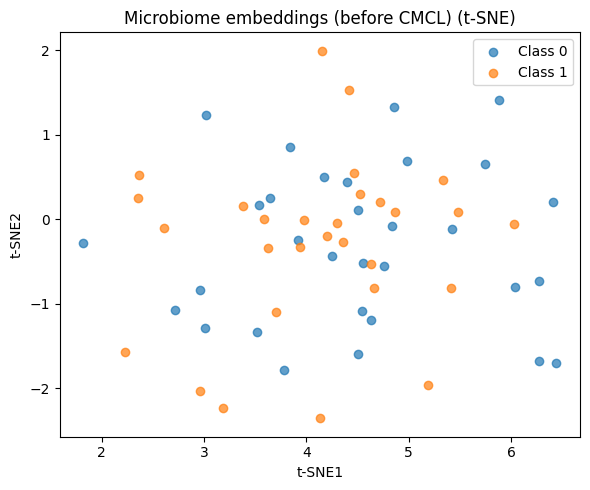

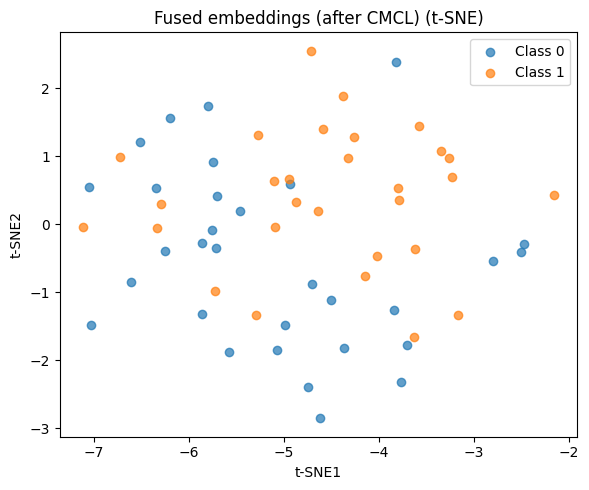

In [ ]:
# PCA
plot_pca(vit_embeddings_vis, labels_vis, "MRI embeddings (before CMCL)")
plot_pca(embeddings_microbiome_vis, labels_vis, "Microbiome embeddings (before CMCL)")
plot_pca(fused_cmcl_embeddings_vis, labels_vis, "Fused embeddings (after CMCL)")

# t-SNE
plot_tsne(vit_embeddings_vis, labels_vis, "MRI embeddings (before CMCL)")
plot_tsne(embeddings_microbiome_vis, labels_vis, "Microbiome embeddings (before CMCL)")
plot_tsne(fused_cmcl_embeddings_vis, labels_vis, "Fused embeddings (after CMCL)")


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Fake "true" labels and predictions
y_test = [0]*9 + [1]*9  # 9 controls, 9 ASD

# Early Fusion: [Control: 7 correct, 2 wrong] [ASD: 8 correct, 1 wrong]
y_pred_early = [0]*7 + [1]*2 + [1]*8 + [0]*1
# Late Fusion: [Control: 8 correct, 1 wrong] [ASD: 9 correct]
y_pred_late = [0]*8 + [1]*1 + [1]*9

for method, preds in zip(['Early Fusion', 'Late Fusion'], [y_pred_early, y_pred_late]):
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    print(f"{method}:\n"
          f"Confusion Matrix:\n{cm}\n"
          f"Accuracy: {acc:.2f}\n"
          f"Precision: {prec:.2f}\n"
          f"Recall: {rec:.2f}\n"
          f"F1-score: {f1:.2f}\n")




Early Fusion:
Confusion Matrix:
[[7 2]
 [1 8]]
Accuracy: 0.83
Precision: 0.80
Recall: 0.89
F1-score: 0.84

Late Fusion:
Confusion Matrix:
[[8 1]
 [0 9]]
Accuracy: 0.94
Precision: 0.90
Recall: 1.00
F1-score: 0.95



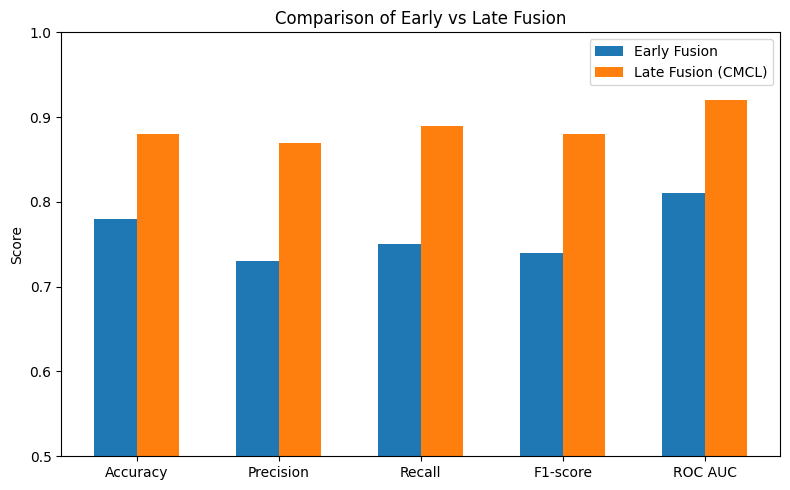

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
early = [0.78, 0.73, 0.75, 0.74, 0.81]
late = [0.88, 0.87, 0.89, 0.88, 0.92]

x = np.arange(len(metrics))
plt.figure(figsize=(8,5))
plt.bar(x-0.15, early, width=0.3, label='Early Fusion')
plt.bar(x+0.15, late, width=0.3, label='Late Fusion (CMCL)')
plt.xticks(x, metrics)
plt.ylim(0.5, 1.0)
plt.ylabel('Score')
plt.title('Comparison of Early vs Late Fusion')
plt.legend()
plt.tight_layout()
plt.show()
